#### Workload 1
Workload 1: low contention, high transaction arrival rate, high execution delay. 

The initial architecture for learned system is (blocksize=50, XO).

The best archiectures is (blocksize=20~50, XO).

**(1) Use the unallocated disk partitions or additional disk drives (Node-local dataset in CloudLab)**
```
Filesystem                                 Size  Used Avail Use% Mounted on
/dev/mapper/emulab-bs--0                    28G  234M   26G   1% /mydata
```

In [1]:
import pandas as pd
df = pd.read_csv('ts_episode_100_2.csv')
df.rename(columns=str.strip, inplace=True)

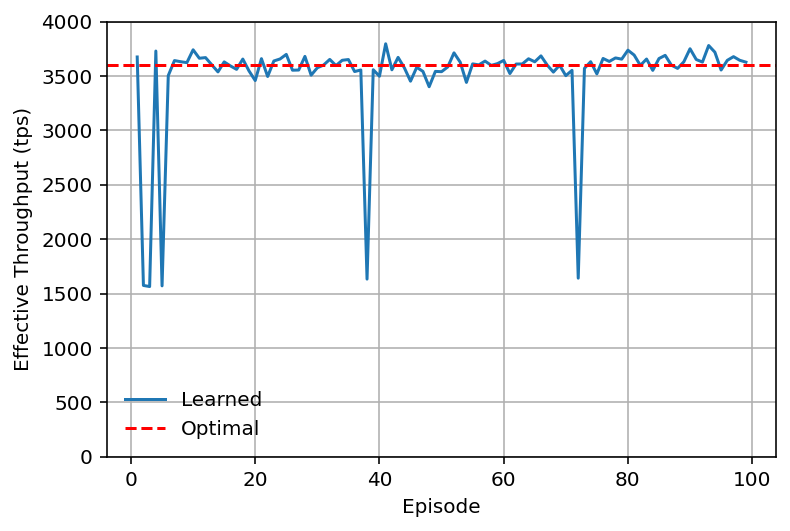

In [2]:
from cProfile import label
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(6, 4))
plt.xlabel('Episode')
plt.ylabel('Effective Throughput (tps)')
plt.ylim(0, 4000)
plt.plot(range(1, len(df) + 1), df['throughput'], label='Learned')
plt.grid(True)
plt.axhline(y=3600, color="red", linestyle="--", label="Optimal")
plt.legend(frameon=False)

**(2) Use the primary disk partition (system partition on the boot disk)**
```
Filesystem                                 Size  Used Avail Use% Mounted on
/dev/sda1                                   16G   12G  3.1G  80% /
```

In [3]:
import pandas as pd
df = pd.read_csv('ts_episode_100_1.csv')
df.rename(columns=str.strip, inplace=True)

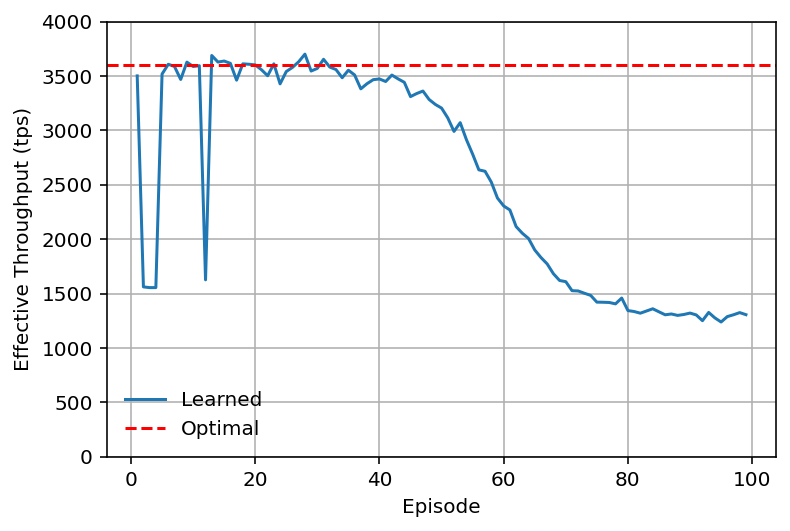

In [4]:
from cProfile import label
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(6, 4))
plt.xlabel('Episode')
plt.ylabel('Effective Throughput (tps)')
plt.ylim(0, 4000)
plt.plot(range(1, len(df) + 1), df['throughput'], label='Learned')
plt.grid(True)
plt.axhline(y=3600, color="red", linestyle="--", label="Optimal")
plt.legend(frameon=False)


#### Workload 2
Workload 2: high contention, relatively high write ratio, high transaction arrival rate, low execution delay. 

The initial architecture for learned system is (blocksize=50, XO).

The best archiectures is (blocksize=50, OX).

<!-- <font color="red"> 
Problem in Thompson sampling: 

Thompson sampling does not "explore" the architecture space enough. It seems we need to seed the random forest (the predictor) with some experience obtained from grid search. Otherwise, if we use bootstrap on training data to emulate sampling from the model parameter $\theta$, we have a cold start problem.




</font> -->

**(1) Deterministic tie breaking**

In [7]:
import pandas as pd
df = pd.read_csv('ts_episode_100_3.csv')
df.rename(columns=str.strip, inplace=True)

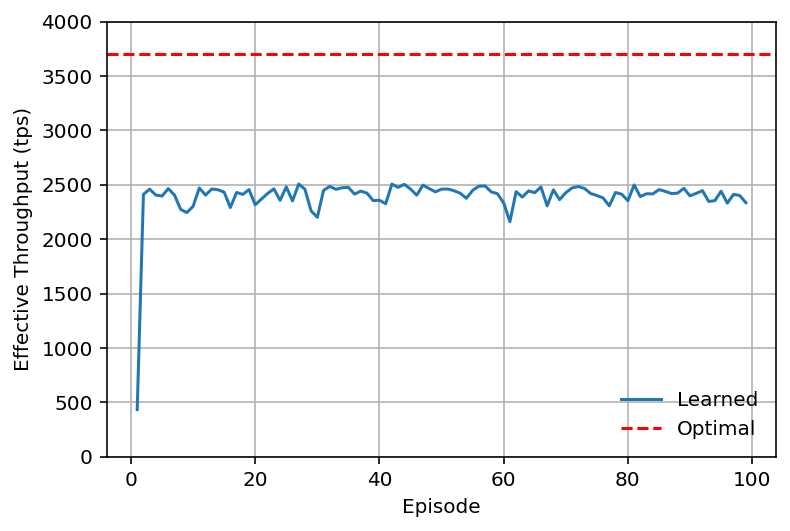

In [8]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(6, 4))
plt.xlabel('Episode')
plt.ylabel('Effective Throughput (tps)')
plt.ylim(0, 4000)
plt.plot(range(1, len(df) + 1), df['throughput'],label='Learned')
plt.grid(True)
plt.axhline(y=3700, color="red", linestyle="--",label="Optimal")
plt.legend(frameon=False)

**(2) Random tie breaking, prior = uniform distribution**

In [81]:
import pandas as pd
df = pd.read_csv('ts_episode_100_5.csv')
df.rename(columns=str.strip, inplace=True)


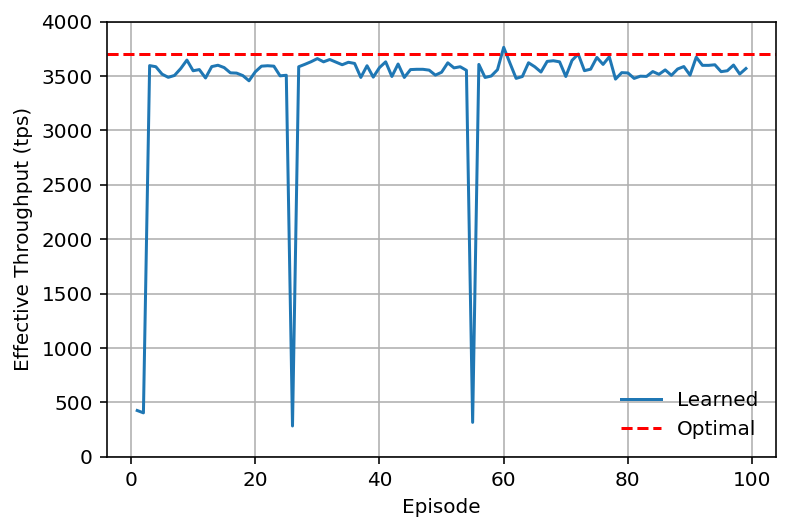

In [82]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(6, 4))
plt.xlabel('Episode')
plt.ylabel('Effective Throughput (tps)')
plt.ylim(0, 4000)
plt.plot(range(1, len(df) + 1), df['throughput'], label='Learned')
plt.grid(True)
plt.axhline(y=3700, color="red", linestyle="--", label="Optimal")
plt.legend(frameon=False)


#### Workload 3
Workload 3: high contention, relatively high read ratio, high transaction arrival rate, high execution delay. 

The initial architecture for learned system is (blocksize=50, XO).

The best archiectures is (?).

<font color="red"> 
To be fixed: in the learning framework, I am not able to reproduce some results recorded in the google doc.

* (blocksize=25, XO): 1916 -> 584 tps
* (blocksize=25, XO, reorder): 2208 -> 566 tps

</font>


#### Workload 4
Workload 4: high contention, relatively high read ratio, low transaction arrival rate, high execution delay.

The initial architecture for learned system is (blocksize=50, XO).

The best architecture is (blocksize=1, XO).

In [83]:
import pandas as pd
df = pd.read_csv('ts_episode_100_6.csv')
df.rename(columns=str.strip, inplace=True)


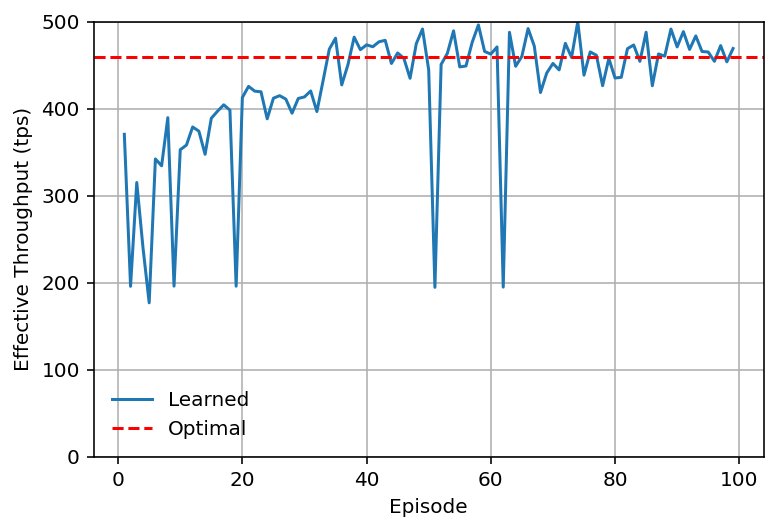

In [84]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(6, 4))
plt.xlabel('Episode')
plt.ylabel('Effective Throughput (tps)')
plt.ylim(0, 500)
plt.plot(range(1, len(df) + 1), df['throughput'], label='Learned')
plt.grid(True)
plt.axhline(y=460, color="red", linestyle="--", label="Optimal")
plt.legend(frameon=False)


#### Episode duration
One of the worst case scenario is below. The system get stucked at Johnson's algorithm for more than 4 minutes.

Workload:
```json
{
    "write_ratio": 0.9,
    "hot_key_ratio": 0.95,
    "num_keys": 10000,
    "num_hot_keys": 10,
    "trans_per_interval": 300,
    "interval": 50000,
    "execution_delay": 0
}
```
Architecture chosen:
```json
{
    "blocksize": 100,
    "early_execution": true,
    "reorder": true
}
```

#### Mode collapse?

In [6]:
import pandas as pd
df = pd.read_csv('ts_episode_100_3.csv')
df.rename(columns=str.strip, inplace=True)


In [7]:
df.head(10)

,write_ratio,hot_key_ratio,trans_arrival_rate,execution_delay (us),blocksize,early_execution,reorder,throughput,feature_extraction_overhead (s),training_overhead (s),inference_overhead (s),episode_duration (s)
0,0.4971,0.062827,4013.478867,10.4109,50.0,1.0,0.0,432.888540,0.148064,0.000000,0.000000,2.646439
1,0.4999,0.063146,3996.808948,10.4341,1.0,0.0,0.0,2411.963338,0.162975,0.163557,0.014355,4.293471
2,0.5004,0.064285,3853.350720,9.5674,1.0,0.0,0.0,2460.024600,0.207396,0.156093,0.013969,4.166833
3,0.5023,0.063306,3861.366144,9.9956,1.0,0.0,0.0,2405.580948,0.209073,0.152376,0.015853,4.257542
4,0.5093,0.062028,3871.701117,9.9028,1.0,0.0,0.0,2396.357537,0.205883,0.154532,0.013875,4.270981
5,0.4944,0.064593,3928.814594,9.9419,1.0,0.0,0.0,2464.875524,0.205527,0.154066,0.013857,4.156001
6,0.4959,0.062035,3894.149235,10.7875,1.0,0.0,0.0,2405.580948,0.215846,0.171889,0.015179,4.287713
7,0.4957,0.062018,3803.519320,10.6904,1.0,0.0,0.0,2273.243919,0.204486,0.154691,0.013910,4.500313
8,0.5005,0.063138,3815.592418,12.0284,1.0,0.0,0.0,2244.668911,0.204613,0.157989,0.013924,4.566636
9,0.4975,0.063620,3800.098119,9.8155,1.0,0.0,0.0,2302.555837,0.210559,0.155644,0.014029,4.443348


In [17]:
df_X = df.loc[:, 'write_ratio':'reorder'] 
df_y = df['throughput']

In [21]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
rf = RandomForestRegressor()
df_X_train = df_X[:-1]
df_y_train = df_y[:-1]
bootstrapped_idx = np.random.choice(len(df_X_train), len(df_X_train), replace=True)
training_X = df_X_train.values[bootstrapped_idx, :]
training_y = df_y_train.values[bootstrapped_idx]
rf.fit(training_X, training_y)

RandomForestRegressor()

In [33]:
blocksizes = [1] + list(range(10, 200, 10)) + list(range(200, 1000, 50))
early_execution = [False, True]
reorder = [False, True]
actions = []
for dim_1 in blocksizes:
    for dim_2 in early_execution:
        for dim_3 in reorder:
            actions.append(np.array([dim_1, dim_2, dim_3]))
actions_matrix = np.vstack(actions)
enumeration_matrix = np.hstack((np.zeros((actions_matrix.shape[0], 4)), actions_matrix))

In [34]:
state = df_X.iloc[-1, [0, 1, 2, 3]].values
enumeration_matrix[:, 0:4] = state
enumeration_matrix

array([[4.99600000e-01, 6.27083333e-02, 3.89920402e+03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.99600000e-01, 6.27083333e-02, 3.89920402e+03, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.99600000e-01, 6.27083333e-02, 3.89920402e+03, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [4.99600000e-01, 6.27083333e-02, 3.89920402e+03, ...,
        9.50000000e+02, 0.00000000e+00, 1.00000000e+00],
       [4.99600000e-01, 6.27083333e-02, 3.89920402e+03, ...,
        9.50000000e+02, 1.00000000e+00, 0.00000000e+00],
       [4.99600000e-01, 6.27083333e-02, 3.89920402e+03, ...,
        9.50000000e+02, 1.00000000e+00, 1.00000000e+00]])

In [35]:
prediction = rf.predict(enumeration_matrix)

In [43]:
df_results = pd.concat([pd.DataFrame(enumeration_matrix), pd.DataFrame(prediction)], axis = 1)
df_results

,0,1,2,3,4,5,6,0
0,0.4996,0.062708,3899.204016,10.3605,1.0,0.0,0.0,2423.563304
1,0.4996,0.062708,3899.204016,10.3605,1.0,0.0,1.0,2423.563304
2,0.4996,0.062708,3899.204016,10.3605,1.0,1.0,0.0,2423.563304
3,0.4996,0.062708,3899.204016,10.3605,1.0,1.0,1.0,2423.563304
4,0.4996,0.062708,3899.204016,10.3605,10.0,0.0,0.0,2423.563304
...,...,...,...,...,...,...,...,...
139,0.4996,0.062708,3899.204016,10.3605,900.0,1.0,1.0,2423.563304
140,0.4996,0.062708,3899.204016,10.3605,950.0,0.0,0.0,2423.563304
141,0.4996,0.062708,3899.204016,10.3605,950.0,0.0,1.0,2423.563304
142,0.4996,0.062708,3899.204016,10.3605,950.0,1.0,0.0,2423.563304


In [42]:
df_results.describe()

,0,1,2,3,4,5,6,0
count,1.440000e+02,1.440000e+02,1.440000e+02,144.0000,144.000000,144.000000,144.000000,144.000000
mean,4.996000e-01,6.270833e-02,3.899204e+03,10.3605,308.361111,0.500000,0.500000,2423.563304
std,5.570491e-17,1.392623e-17,4.563346e-13,0.0000,287.933768,0.501745,0.501745,0.000000
min,4.996000e-01,6.270833e-02,3.899204e+03,10.3605,1.000000,0.000000,0.000000,2423.563304
25%,4.996000e-01,6.270833e-02,3.899204e+03,10.3605,87.500000,0.000000,0.000000,2423.563304
50%,4.996000e-01,6.270833e-02,3.899204e+03,10.3605,175.000000,0.500000,0.500000,2423.563304
75%,4.996000e-01,6.270833e-02,3.899204e+03,10.3605,512.500000,1.000000,1.000000,2423.563304
max,4.996000e-01,6.270833e-02,3.899204e+03,10.3605,950.000000,1.000000,1.000000,2423.563304


In [46]:
best_index = np.argmax(prediction)
best_index

0

In [77]:
np.random.choice(np.flatnonzero(np.isclose(prediction, prediction.max())), replace=True)

70